# Ouverture et traitement des colonnes des fichiers brutes TD seance 1

In [13]:
francisco

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import matplotlib.dates as mdates
from IPython.display import Image

# Fonctions traitement base donnee TD seance 1

def detect_separator(chemin_fichier):
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        return sniffer.sniff(sample_data).delimiter

def load_data(chemin_capteur_riviere, chemin_capteur_ZH, chemin_etalonage_capteur_riv):
    separator_riviere = detect_separator(chemin_capteur_riviere)
    separator_ZH = detect_separator(chemin_capteur_ZH)
    
    capteur_riviere = pd.read_csv(chemin_capteur_riviere, sep=separator_riviere, skiprows=1 if "Titre" in open(chemin_capteur_riviere).readline() else 0)
    capteur_ZH = pd.read_csv(chemin_capteur_ZH, sep=separator_ZH, skiprows=1 if "Titre" in open(chemin_capteur_ZH).readline() else 0)
    
    separator_etalonage_capteur_riv = detect_separator(chemin_etalonage_capteur_riv)
    etalonage_capteur_riv = pd.read_csv(chemin_etalonage_capteur_riv, sep=separator_etalonage_capteur_riv)
    
    return capteur_riviere, capteur_ZH, etalonage_capteur_riv

def remove_columns_by_partial_name(df, partial_name):
    columns_to_remove = [col for col in df.columns if partial_name in col]
    df = df.drop(columns=columns_to_remove, errors='ignore')
    return df



def process_data(capteur_riviere, capteur_ZH, etalonage_capteur_riv, constant_date_format = False):

    partial_names = ['#','Hôte connecté', 'Arrêté', 'Fin de fichier']

    for partial_name in partial_names:
        capteur_riviere = remove_columns_by_partial_name(capteur_riviere, partial_name)
        capteur_ZH = remove_columns_by_partial_name(capteur_ZH, partial_name)

    capteur_riviere= capteur_riviere.iloc[:,:3]


    nombre_de_colonnes_riviere = capteur_riviere.shape[1]
    # Imprimer les noms des colonnes du DataFrame riviere
    print("\nNoms des colonnes de capteur_riviere:",nombre_de_colonnes_riviere)

    nombre_de_colonnes_ZH = capteur_ZH.shape[1]
    print("\nNombre de colonnes dans capteur_ZH :", nombre_de_colonnes_ZH)

    # Renommez les colonnes en fonction de leur position
    capteur_ZH.columns = [ 'dates', 'temperature_depth_1_C', 'temperature_depth_2_C', 'temperature_depth_3_C', 'temperature_depth_4_C']
    capteur_riviere.columns = [ 'dates', 'tension_V', 'temperature_stream_C']

    # Essayez de convertir les dates en utilisant plusieurs formats possibles
    if not constant_date_format:
        capteur_riviere['dates_parsed'] = pd.to_datetime(capteur_riviere['dates'],   format="mixed", errors='coerce')
        capteur_ZH['dates_parsed'] = pd.to_datetime(capteur_ZH['dates'],   format="mixed", errors='coerce')

    # Trouver la periode commune entre les deux capteurs
    common_start_date = max(capteur_riviere['dates_parsed'].min(), capteur_ZH['dates_parsed'].min())
    common_end_date = min(capteur_riviere['dates_parsed'].max(), capteur_ZH['dates_parsed'].max())

    # Extraire la periode commune
    capteur_riviere = capteur_riviere[(capteur_riviere['dates_parsed'] >= common_start_date) & (capteur_riviere['dates_parsed'] <= common_end_date)]
    capteur_ZH = capteur_ZH[(capteur_ZH['dates_parsed'] >= common_start_date) & (capteur_ZH['dates_parsed'] <= common_end_date)]

    # Imprimer les début et fin
    print("Début:", common_start_date)
    print("Fin:", common_end_date)

    # Calculer le nombre de jour de la période
    common_duration = (common_end_date - common_start_date).days

    # Print the common period duration in days
    print("Durée de l'experience (jours):", common_duration)

    etalonage_capteur_riv = etalonage_capteur_riv.set_index('Sensor_Name')

   # Obtenez les indices des cinq dernières lignes
    indices_float = etalonage_capteur_riv.index[-4:]

    # Convertissez les valeurs des cinq dernières lignes en float, en excluant les lignes non convertibles
    etalonage_capteur_riv.loc[indices_float] = etalonage_capteur_riv.loc[indices_float].apply(pd.to_numeric, errors='coerce')
    # Obtenez les valeurs de 'Intercept', 'dU/dH' et 'dU/dT' en utilisant les noms de colonnes
    k0 = etalonage_capteur_riv.loc['Intercept', 'P508']
    k1 = etalonage_capteur_riv.loc['dU/dH', 'P508']
    k2 = etalonage_capteur_riv.loc['dU/dT', 'P508']

    # Affichez les valeurs
    print("k0 =", k0)
    print("k1 =", k1)
    print("k2 =", k2)


    # Calcul de la colonne 'dH' en utilisant les valeurs du DataFrame 'capteur_riviere'
    capteur_riviere['dH'] = (1 / k1) * (capteur_riviere['tension_V'].astype(float) - k0 - k2 * capteur_riviere['temperature_stream_C'].astype(float))
  
    

    return capteur_riviere, capteur_ZH, etalonage_capteur_riv

def plot_data(capteur_riviere, capteur_ZH):
    # Create a figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 'dH' data on the first subplot
    ax1.plot(capteur_riviere["dates_parsed"], capteur_riviere["dH"], color="black", label="dH")
    ax1.set_ylabel("dH")

    # List of temperature columns for capteur_ZH
    temp_columns_ZH = ["temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]

    # Plot temperature data for capteur_ZH on the second subplot
    for column in temp_columns_ZH:
        ax2.plot(capteur_ZH["dates_parsed"], capteur_ZH[column], label=column.replace("_", " "), alpha=0.7)

    # Plot river temperature data on the second subplot
    ax2.plot(capteur_riviere["dates_parsed"], capteur_riviere["temperature_stream_C"], color="red", label="Température Rivière")

    # Configure labels and legend for the second subplot
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Température (°C)")
    ax2.legend()

    # Add legends to each subplot
    ax1.legend()

    # Format dates on the x-axis
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M:%S'))

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Display the figure
    plt.tight_layout()
    plt.show()




def visualize_data(capteur_riviere, capteur_ZH):
    # Boxplot for temperature_depth columns in capteur_ZH
    capteur_ZH.boxplot(figsize=(8, 6), column=["temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"])
    plt.xticks(rotation=15)
    plt.title("Boxplot for temperature_depth in capteur_ZH")
    plt.show()

    # Boxplot for temperature_stream_C in capteur_riviere
    capteur_riviere[["temperature_stream_C"]].boxplot(figsize=(8, 6))
    plt.title("Boxplot for temperature_stream_C in capteur_riviere")
    plt.show()

    # Histograms for temperature_depth columns in capteur_ZH
    capteur_ZH[["temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]].hist(bins=100, figsize=(20, 4), layout=(1, 4))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.title("Histograms for temperature_depth in capteur_ZH")
    plt.show()

    # Scatter plots between temperature_stream_C and temperature_depth columns
    df = capteur_ZH[["dates_parsed", "temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]].copy()
    df["temperature_stream_C"] = capteur_riviere[["temperature_stream_C"]]
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    ax1 = df.plot.scatter(x=['temperature_stream_C'], y=['temperature_depth_1_C'], ax=axs[0, 0])
    ax2 = df.plot.scatter(x=['temperature_stream_C'], y=['temperature_depth_2_C'], ax=axs[0, 1])
    ax3 = df.plot.scatter(x=['temperature_stream_C'], y=['temperature_depth_3_C'], ax=axs[1, 0])
    ax4 = df.plot.scatter(x=['temperature_stream_C'], y=['temperature_depth_4_C'], ax=axs[1, 1])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.suptitle("Scatter Plots between temperature_stream_C and temperature_depth columns")
    plt.show()





# Figure du dispositif

In [7]:
# Spécifiez le chemin de votre fichier PNG
chemin_image = './sampling_points/Point034/point34_schema.png'

# Affichez l'image dans le notebook
Image(filename=chemin_image)

FileNotFoundError: [Errno 2] No such file or directory: './sampling_points/Point034/point34_schema.png'

# Ouverture des données et impression des informations utiles

In [8]:
if __name__ == "__main__":
    #point 034
    chemin_capteur_riviere_034 = "./sampling_points/Point034/point034_P_measures.csv"
    chemin_capteur_ZH_034 = "./sampling_points/Point034/point034_T_measures.csv"
    chemin_etalonage_capteur_riv_034 = "./configuration/pressure_sensors/P508.csv"
    capteur_riviere_034, capteur_ZH_034, etalonage_capteur_riv_034 = load_data(chemin_capteur_riviere_034, chemin_capteur_ZH_034, chemin_etalonage_capteur_riv_034)
    capteur_riviere_034, capteur_ZH_034, etalonage_capteur_riv_034 = process_data(capteur_riviere_034, capteur_ZH_034, etalonage_capteur_riv_034)
    # point 036
    chemin_capteur_riviere_036 = "./sampling_points/Point036/p36_p_03_08_16.csv"
    chemin_capteur_ZH_036 = "./sampling_points/Point036/p36_t_03_08_16.csv"
    chemin_etalonage_capteur_riv_036 = "./configuration/pressure_sensors/P508.csv"
    capteur_riviere_036, capteur_ZH_036, etalonage_capteur_riv_036 = load_data(chemin_capteur_riviere_036, chemin_capteur_ZH_036, chemin_etalonage_capteur_riv_036)
    capteur_riviere_036, capteur_ZH_036, etalonage_capteur_riv_036 = process_data(capteur_riviere_036, capteur_ZH_036, etalonage_capteur_riv_036)
    
    # pour les deux points suivants, il a fallu modifier la fonction process_data pour que les dates soient au format jour/mois/année
    # Point 046
    chemin_capteur_riviere_046 = "./sampling_points/Point046/point046_P_measures.csv"
    chemin_capteur_ZH_046 = "./sampling_points/Point046/point046_T_measures.csv"
    chemin_etalonage_capteur_riv_046 = "./configuration/pressure_sensors/P508.csv"
    capteur_riviere_046, capteur_ZH_046, etalonage_capteur_riv_046 = load_data(chemin_capteur_riviere_046, chemin_capteur_ZH_046, chemin_etalonage_capteur_riv_046)
    capteur_riviere_046, capteur_ZH_046, etalonage_capteur_riv_046 = process_data(capteur_riviere_046, capteur_ZH_046, etalonage_capteur_riv_046, constant_date_format = True)
    # Point 047
    chemin_capteur_riviere_047 = "./sampling_points/Point047/point047_P_measures.csv"
    chemin_capteur_ZH_047 = "./sampling_points/Point047/point047_T_measures.csv"
    chemin_etalonage_capteur_riv_047 = "./configuration/pressure_sensors/P508.csv"
    capteur_riviere_047, capteur_ZH_047, etalonage_capteur_riv_047 = load_data(chemin_capteur_riviere_047, chemin_capteur_ZH_047, chemin_etalonage_capteur_riv_047)
    capteur_riviere_047, capteur_ZH_047, etalonage_capteur_riv_047 = process_data(capteur_riviere_047, capteur_ZH_047, etalonage_capteur_riv_047, constant_date_format=True)

FileNotFoundError: [Errno 2] No such file or directory: './sampling_points/Point034/point034_P_measures.csv'

# Plot des donnees brutes

### Point 034

In [9]:
plot_data(capteur_riviere_034, capteur_ZH_034)
plt.show()

NameError: name 'capteur_riviere_034' is not defined

### Point 036

In [10]:
plot_data(capteur_riviere_036, capteur_ZH_036)
plt.show()

NameError: name 'capteur_riviere_036' is not defined

### Remarque    
On voit ici que la valeur `temperature_depth_4_C` est faussée, elle oscille entre 400 et 500°C ce qui signifie que le capteur associé ne fonctionne pas. On va donc mettre cette valeur constante à 15°C dans la suite du TP pour pouvoir observer les autres température (ce qui est impossible sur le graphe précédent).

In [11]:
capteur_ZH_036["temperature_depth_4_C"] = 0
plot_data(capteur_riviere_036, capteur_ZH_036)
plt.show()

NameError: name 'capteur_ZH_036' is not defined

### Point 046

In [12]:
plot_data(capteur_riviere_046, capteur_ZH_046)

NameError: name 'capteur_riviere_046' is not defined

### Point 047

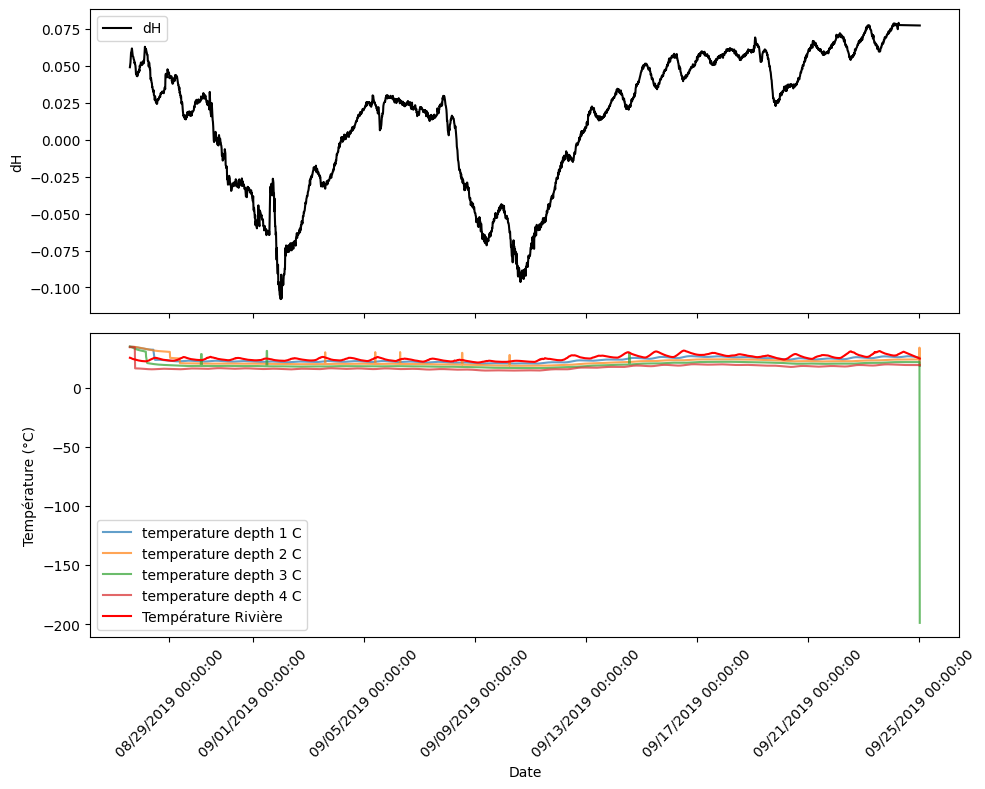

In [9]:
plot_data(capteur_riviere_047, capteur_ZH_047)

# Visualisation des anomalies

### Point 034

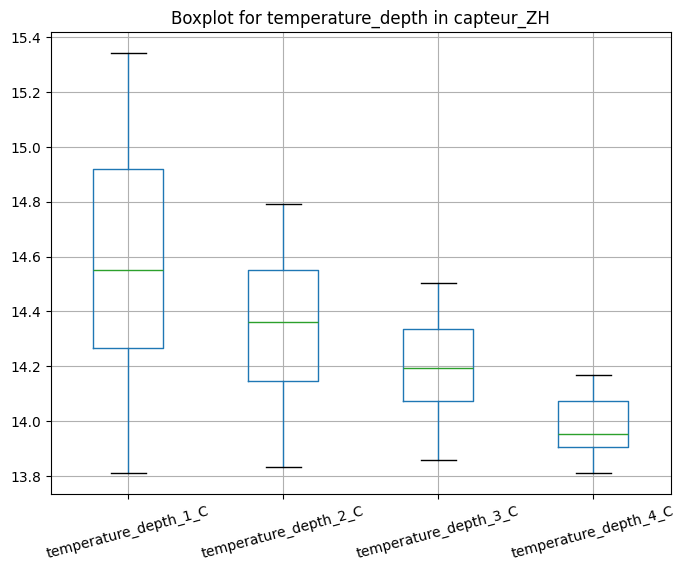

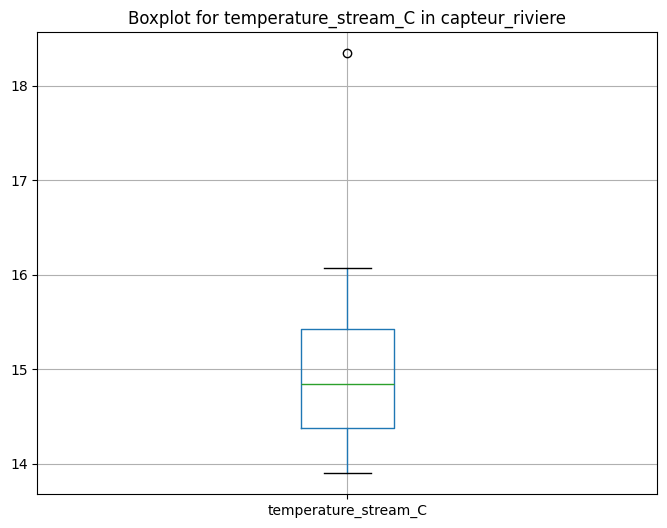

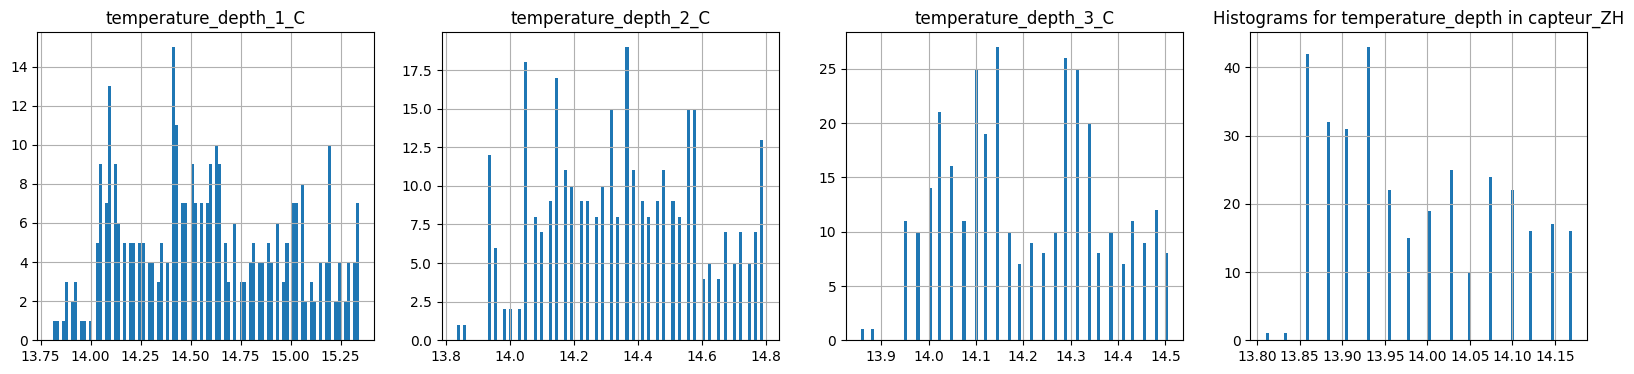

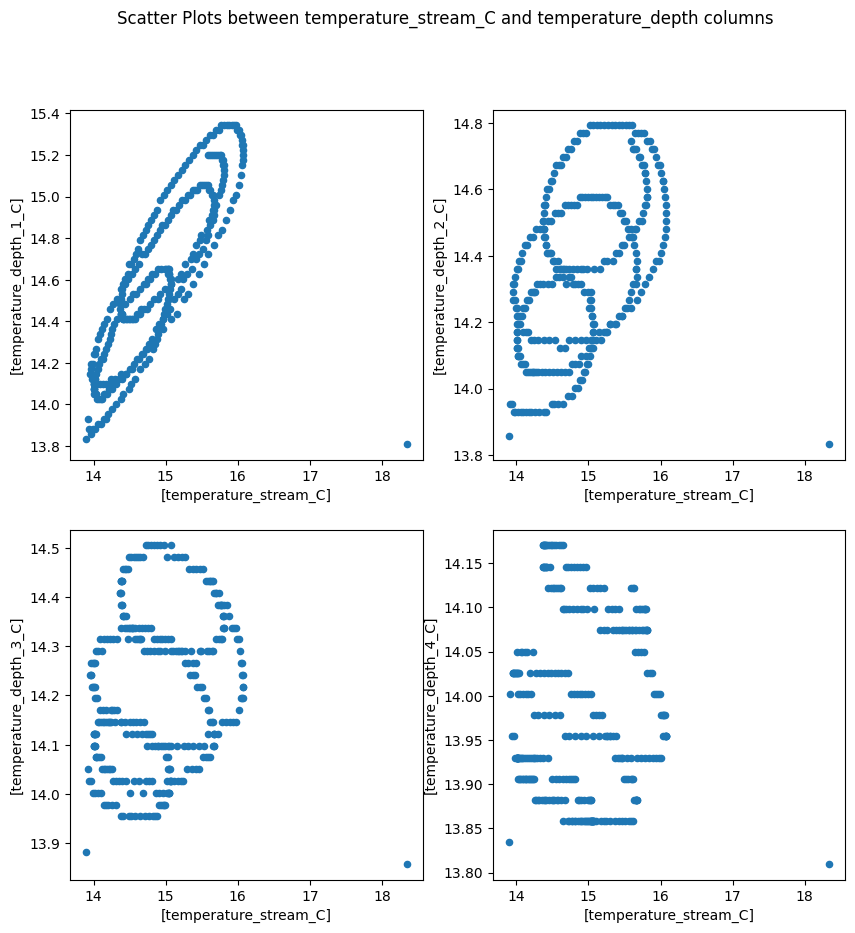

In [10]:
visualize_data(capteur_riviere_034, capteur_ZH_034)

### Point 036

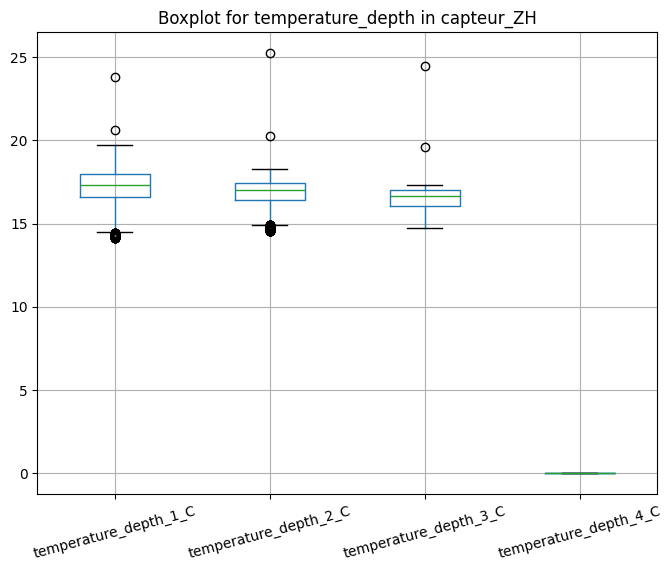

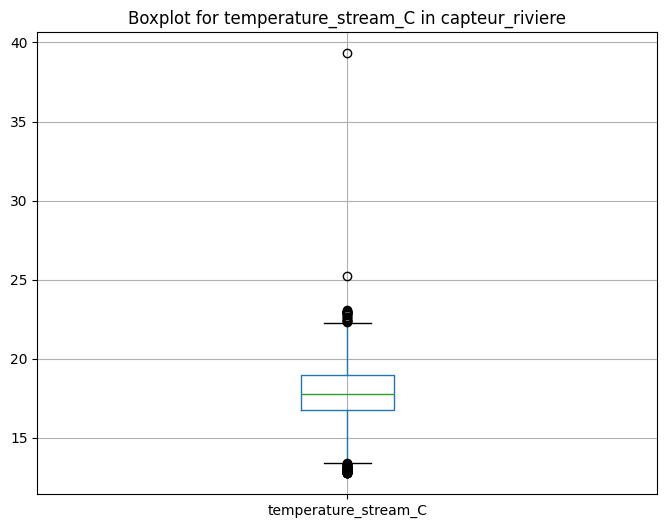

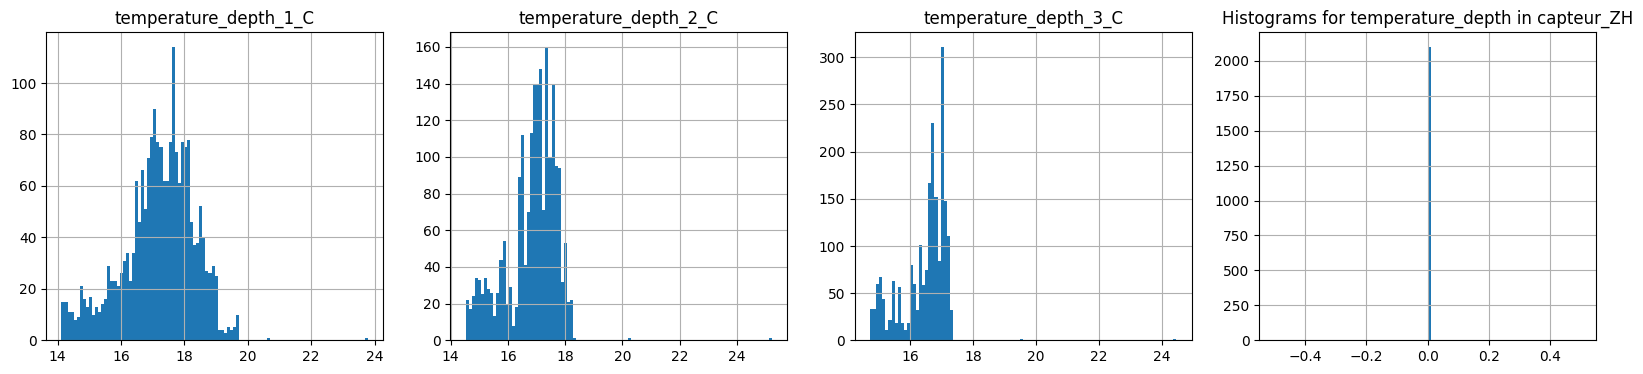

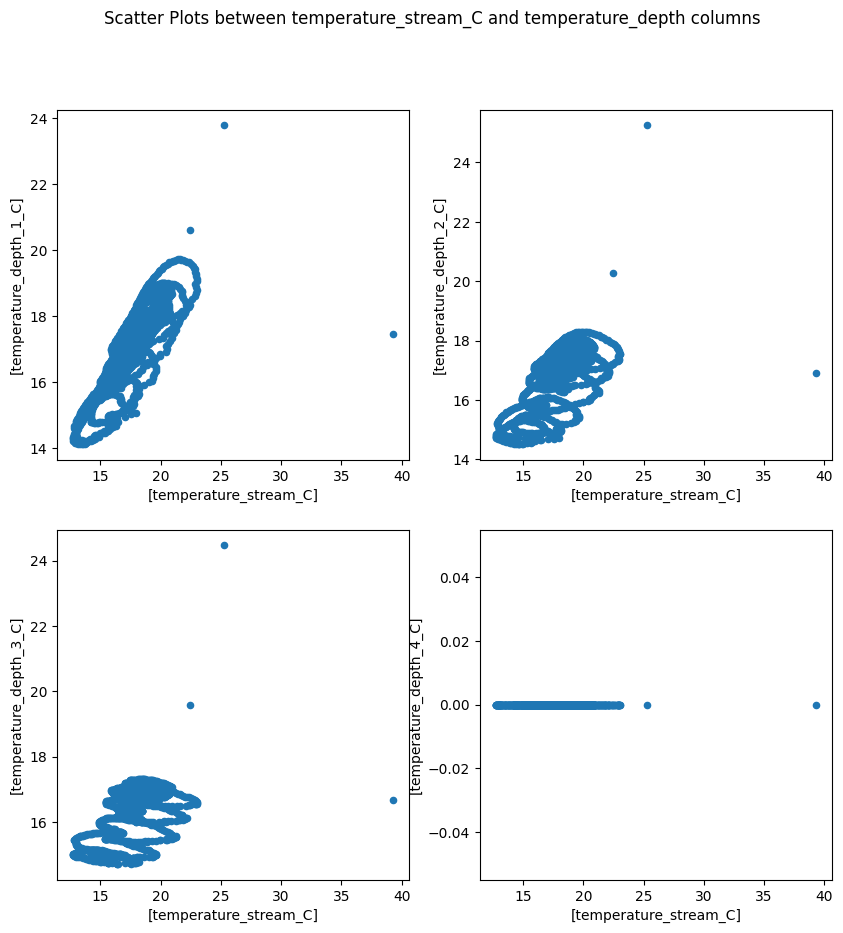

In [11]:
visualize_data(capteur_riviere_036, capteur_ZH_036)

### Point 046

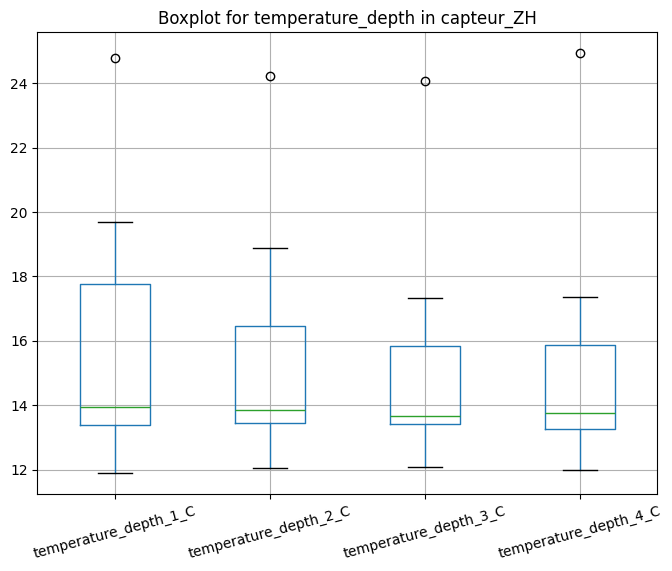

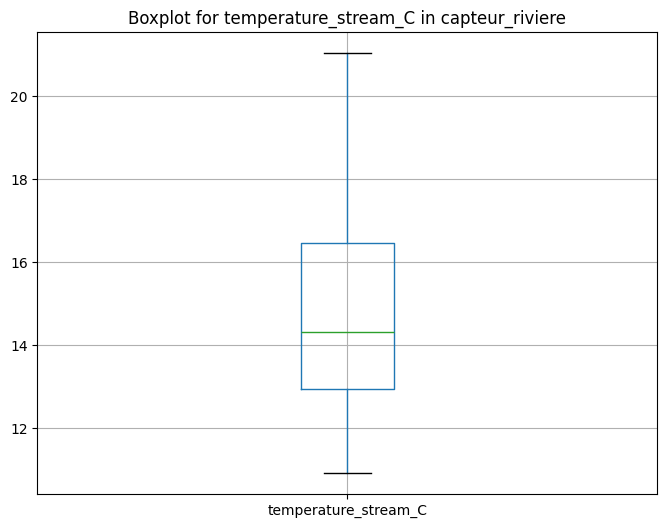

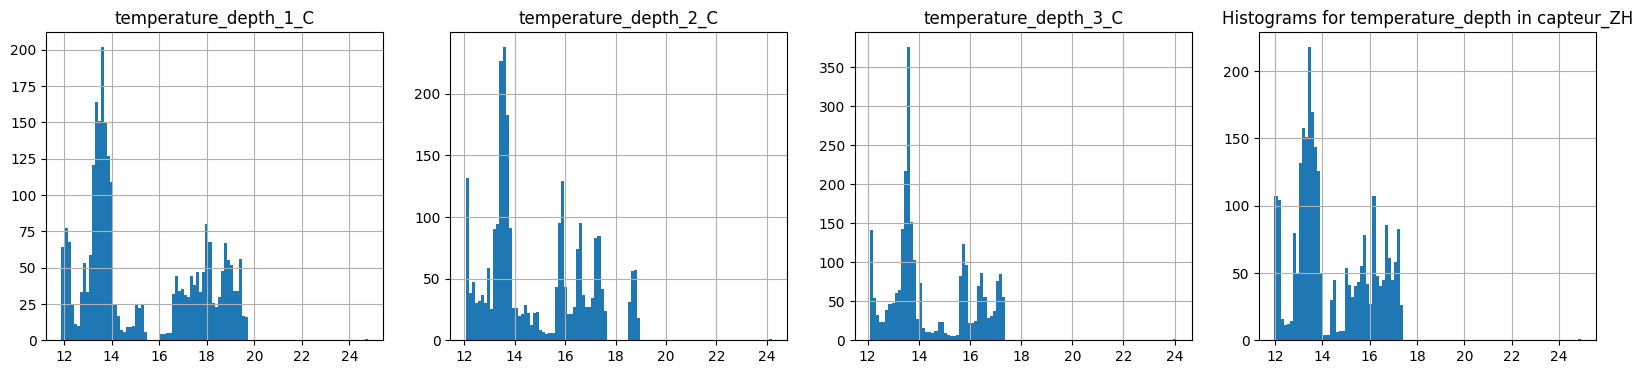

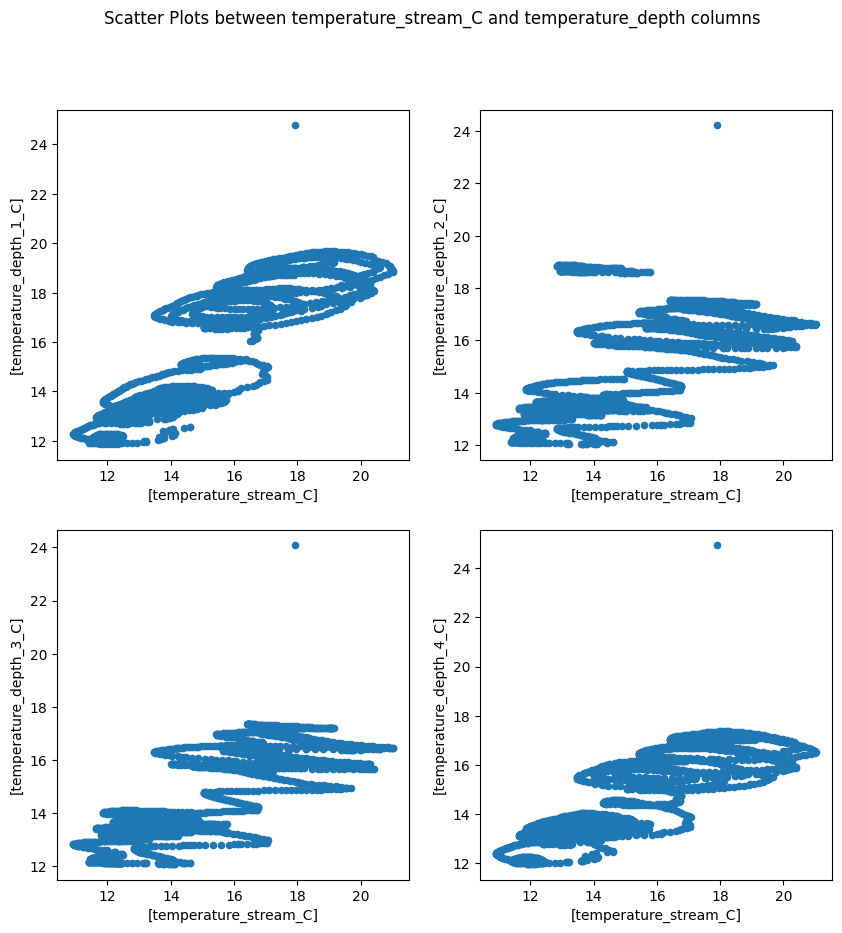

In [12]:
visualize_data(capteur_riviere_046, capteur_ZH_046)

### Point 047

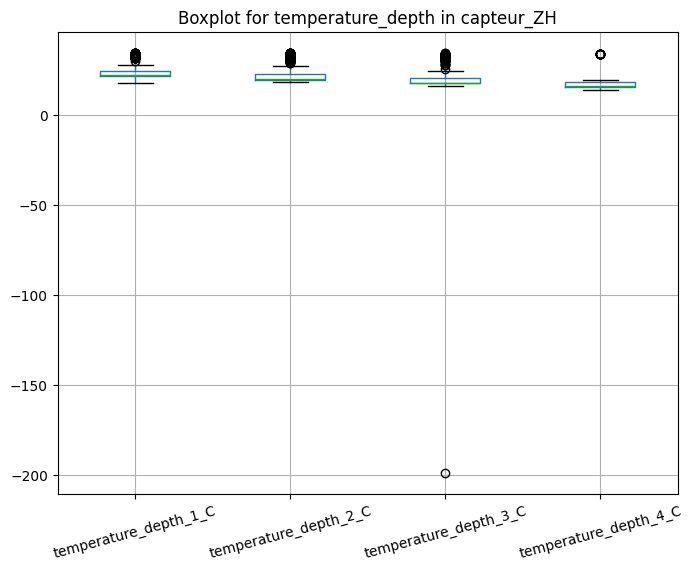

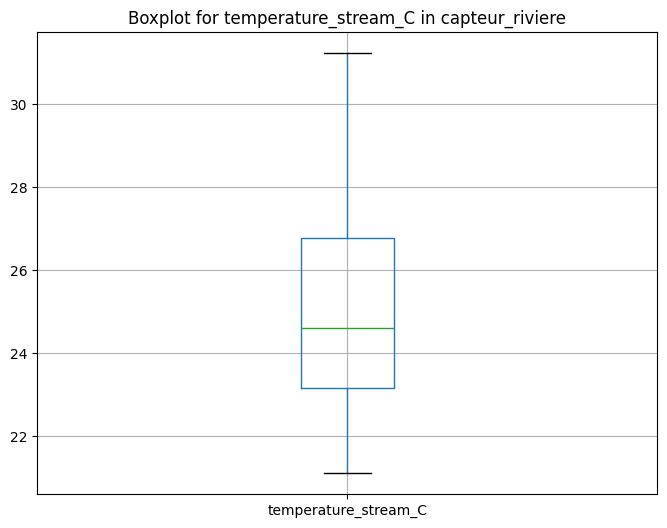

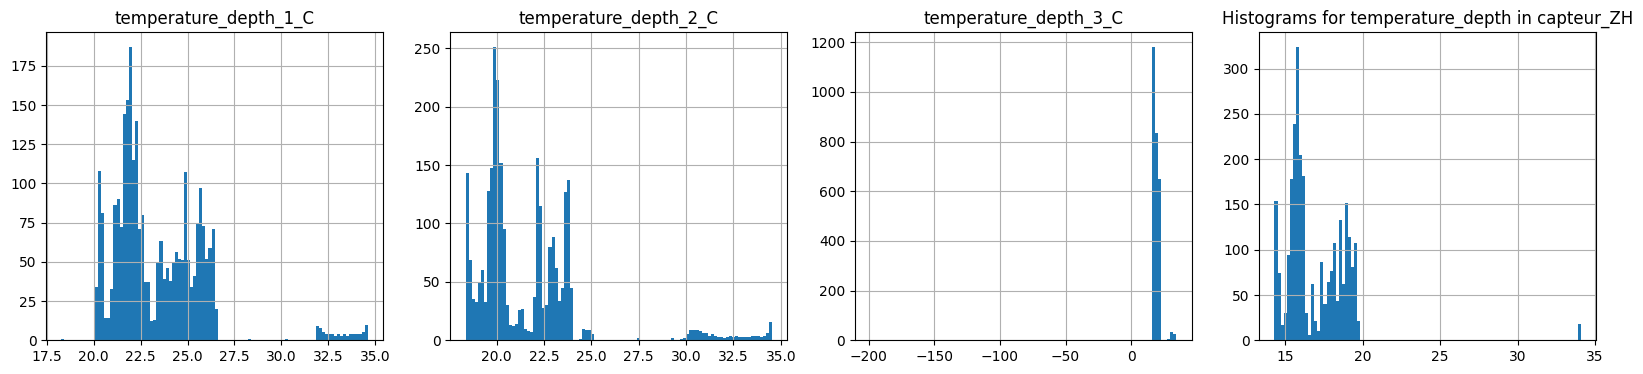

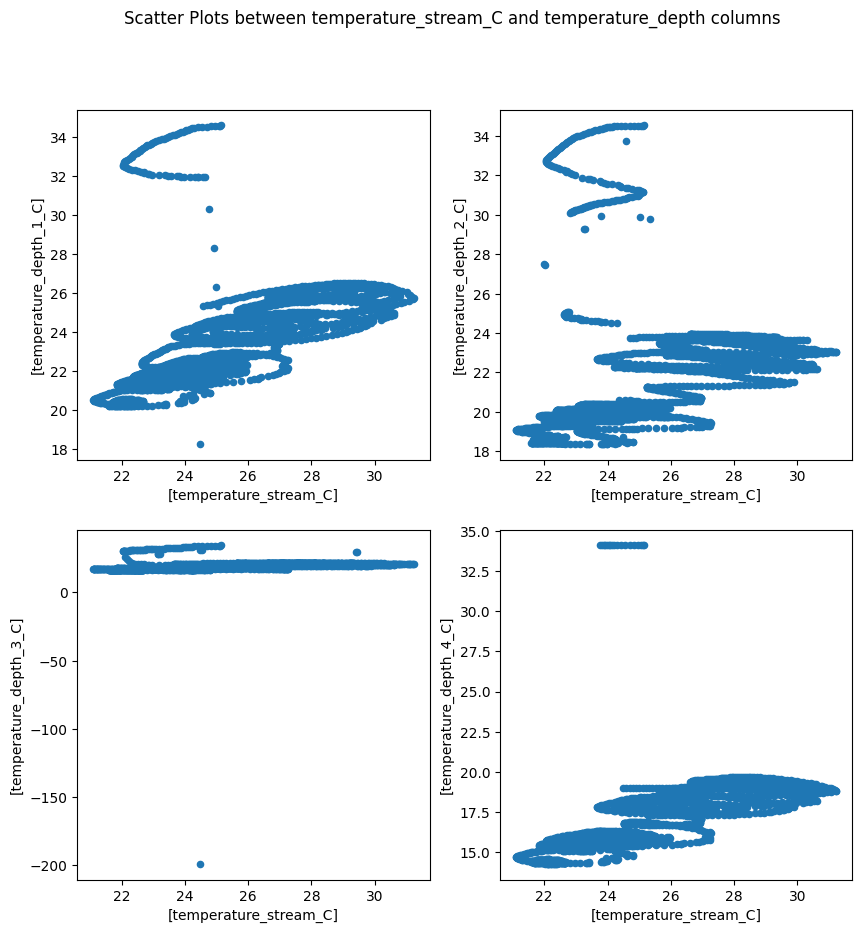

In [13]:
visualize_data(capteur_riviere_047, capteur_ZH_047)

# Identification des valeurs aberrantes avec l'écart interquartile (IQR)

L'écart interquartile (IQR) est une mesure de la dispersion statistique et est calculé comme la différence entre les 75e et 25e percentiles. Il est représenté par la formule IQR = Q3 - Q1. Les  lignes de code ci-dessous calculent et impriment l'écart interquartile pour chacune des variables de l'ensemble de données.  La règle générale est que tout ce qui n'est pas dans la plage de (Q1 - 1,5 IQR) et (Q3 + 1,5 IQR) est une valeur aberrante et peut être supprimé.

In [14]:
# Fonction pour calculer les statistiques et les valeurs IQR
def calculate_quantiles_iqr(df, column_name):
    median = df[column_name].median()
    # Calculer les quantiles Q1 et Q3 pour la colonne spécifiée
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calculer l'IQR
    iqr = q3 - q1
    minimum = q1 - 1.5 * iqr  # Valeur minimale (|- dans la boîte à moustaches)
    maximum = q3 + 1.5 * iqr  # Valeur maximale (-| dans la boîte à moustaches)
    return median, q1, q3, iqr, minimum, maximum

# Fonction pour obtenir un texte décrivant les statistiques de base
def get_iqr_text(df, col_name):
    # Calcul des statistiques de base
    median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Création du texte
    text = f"médiane={median:.2f}, Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

# Fonction pour supprimer les valeurs aberrantes
def remove_outliers(df, col_name):
    # Obtention des limites pour les valeurs non aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Sélection des lignes avec des valeurs non aberrantes
    df_out = df.loc[(df[col_name] > minimum) & (df[col_name] < maximum)]
    return df_out

# Fonction pour compter les valeurs aberrantes
def count_outliers(df_in, col_name):
    # Obtention des limites pour les valeurs aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df_in, col_name)
    
    # Sélection des lignes avec des valeurs aberrantes
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    
    # Comptage des valeurs aberrantes
    num_outliers = df_outliers.shape[0]
    return num_outliers

# Fonction pour générer un graphique de boîte à moustaches
def box_and_whisker(df_in, col_name):
    # Obtention du texte décrivant les statistiques
    title = get_iqr_text(df_in, col_name)
    
    # Tracé du graphique de boîte à moustaches
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

# Fonction pour tracer les données avec et sans valeurs aberrantes
def plot_data_with_and_without_outliers(df, col_name):
    plt.figure(figsize=(12, 6))
    
    # Tracé des données brutes
    plt.subplot(1, 2, 1)
    plt.title("Données brutes")
    sns.boxplot(df[col_name])
    
    # Tracé des données sans valeurs aberrantes
    plt.subplot(1, 2, 2)
    plt.title("Données sans valeurs aberrantes")
    df_cleaned = remove_outliers(df, col_name)
    sns.boxplot(df_cleaned[col_name])
    
    plt.tight_layout()
    plt.show()


In [5]:
def nb_val_abberantes(capteur_riviere, capteur_ZH):
    df = capteur_ZH[["dates_parsed", "temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]].copy()
    df["temperature_stream_C"] = capteur_riviere[["temperature_stream_C"]]
    df["dH"] = capteur_riviere[["dH"]]
    for column in df.columns:
        if column != "dates_parsed":
            print(f"Analyse pour la colonne : {column}")
            #plot_data_with_and_without_outliers(df, column)
            print(f"Nombre de valeurs aberrantes : {count_outliers(df, column)}\n")
            
    # Créer un DataFrame vide pour stocker les données traitées
    df_processed = df[["dates_parsed"]].copy()

    # Boucler à travers chaque colonne de df
    for column_name in df.columns:
        if column_name == "dates_parsed":
            continue  # Ignorer la colonne des dates
            
        # Traiter la colonne et stocker les données traitées dans df_processed
        median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, column_name)
        df_processed[f"{column_name}_processed"] = remove_outliers(df, column_name)[column_name]
        
    # Afficher les statistiques des données traitées
    print(df_processed.describe())
    return df, df_processed


### Point 034

In [4]:
df_034, df_processed_034 = nb_val_abberantes(capteur_riviere_034, capteur_ZH_034)

NameError: name 'nb_val_abberantes' is not defined

### Point 036

In [17]:
nb_val_abberantes(capteur_riviere_036, capteur_ZH_036)

Analyse pour la colonne : temperature_depth_1_C
Nombre de valeurs aberrantes : 50

Analyse pour la colonne : temperature_depth_2_C
Nombre de valeurs aberrantes : 83

Analyse pour la colonne : temperature_depth_3_C
Nombre de valeurs aberrantes : 2

Analyse pour la colonne : temperature_depth_4_C
Nombre de valeurs aberrantes : 2099

Analyse pour la colonne : temperature_stream_C
Nombre de valeurs aberrantes : 66

Analyse pour la colonne : dH
Nombre de valeurs aberrantes : 448

                        dates_parsed  temperature_depth_1_C_processed  \
count                           2099                      2047.000000   
mean   2016-07-23 12:14:59.234873600                        17.247677   
min              2016-07-12 14:00:00                        14.481000   
25%              2016-07-18 01:07:30                        16.654000   
50%              2016-07-23 12:15:00                        17.320000   
75%              2016-07-28 23:22:30                        17.986000   
max      

### Point 046

In [18]:
nb_val_abberantes(capteur_riviere_046, capteur_ZH_046)

Analyse pour la colonne : temperature_depth_1_C
Nombre de valeurs aberrantes : 1

Analyse pour la colonne : temperature_depth_2_C
Nombre de valeurs aberrantes : 1

Analyse pour la colonne : temperature_depth_3_C
Nombre de valeurs aberrantes : 1

Analyse pour la colonne : temperature_depth_4_C
Nombre de valeurs aberrantes : 1

Analyse pour la colonne : temperature_stream_C
Nombre de valeurs aberrantes : 0

Analyse pour la colonne : dH
Nombre de valeurs aberrantes : 0

                        dates_parsed  temperature_depth_1_C_processed  \
count                           2656                      2655.000000   
mean   2019-07-01 07:52:30.000000256                        15.255462   
min              2019-06-17 12:00:00                        11.886272   
25%              2019-06-24 09:56:15                        13.396429   
50%              2019-07-01 07:52:30                        13.937405   
75%              2019-07-08 05:48:45                        17.758692   
max              

### Point 047

In [19]:
nb_val_abberantes(capteur_riviere_047, capteur_ZH_047)

Analyse pour la colonne : temperature_depth_1_C
Nombre de valeurs aberrantes : 83

Analyse pour la colonne : temperature_depth_2_C
Nombre de valeurs aberrantes : 145

Analyse pour la colonne : temperature_depth_3_C
Nombre de valeurs aberrantes : 65

Analyse pour la colonne : temperature_depth_4_C
Nombre de valeurs aberrantes : 18

Analyse pour la colonne : temperature_stream_C
Nombre de valeurs aberrantes : 0

Analyse pour la colonne : dH
Nombre de valeurs aberrantes : 0

              dates_parsed  temperature_depth_1_C_processed  \
count                 2731                      2648.000000   
mean   2019-09-10 19:15:00                        23.105678   
min    2019-08-27 14:00:00                        18.277288   
25%    2019-09-03 16:37:30                        21.693787   
50%    2019-09-10 19:15:00                        22.454312   
75%    2019-09-17 21:52:30                        24.841124   
max    2019-09-25 00:30:00                        28.331469   
std                

## Figure avec et sans valeurs abérantes
### fonction plot all data

In [ ]:
capteur_ZH_process1=df_processed[["dates_parsed", "temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]].copy()
capteur_riviere_process1=df_processed[["dates_parsed","temperature_stream_C","dH"]].copy()


plot_data(capteur_riviere_process1, capteur_ZH_process1)

KeyError: "['temperature_depth_1_C', 'temperature_depth_2_C', 'temperature_depth_3_C', 'temperature_depth_4_C'] not in index"

# Valeurs abérantes avec la méthode score Z 
Il s'agit d'une unité mesurée en écart-type. Fondamentalement, il s'agit d'une mesure de la distance entre le score brut et la moyenne. Il est compris entre -3 et +3, où 0 = moyenne et 1 = écart-type, c'est-à-dire une distribution normale.

Cette méthode suggère qu'en tout point de données il existe une relation entre l'écart-type et la moyenne. Le score Z permet de trouver la distribution des données où la moyenne est égale à 0 et l'écart-type à 1, c'est-à-dire une distribution normale. Vous devez vous demander en quoi cela peut nous aider à identifier les valeurs aberrantes ? 


Le score Z est un concept important en statistique. Le score Z est également appelé score standard. Ce score permet de comprendre si une valeur de données est supérieure ou inférieure à la moyenne et à quel point elle s'en éloigne. Plus précisément, le score Z indique le nombre d'écarts types d'un point de données par rapport à la moyenne.

        Z score = (x -mean) / std. deviation

Une distribution normale est représentée ci-dessous et on estime que
* 68% des points de données se situent entre +/- 1 écart-type.
* 95 % des points de données se situent entre +/- 2 écarts types
* 99,7 % des points de données se situent entre +/- 3 écarts types.


En calculant le score Z, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Ces points de données qui sont trop éloignés de zéro seront traités comme des valeurs aberrantes. Dans la plupart des cas, un seuil de 3 ou -3 est utilisé, c'est-à-dire que si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme aberrant.



In [95]:
from scipy import stats
# Fonction pour détecter et supprimer les valeurs aberrantes en utilisant le Z-score
def remove_outliers_z_score(df, col_name, threshold=3):
    z_scores = np.abs(stats.zscore(df[col_name]))
    df_cleaned = df[(z_scores < threshold)]
    return df_cleaned


# Traiter chaque colonne sauf la colonne des dates
columns_to_process = [col for col in df.columns if col != "dates_parsed"]

# Créer un DataFrame vide pour stocker les données traitées
df_processed2 = df[["dates_parsed"]].copy()

# Boucler à travers chaque colonne à traiter
for column_name in columns_to_process:
    # Calculer le Z-score pour la colonne
    z_scores = np.abs(stats.zscore(df[column_name]))
    
    # Définir un seuil pour le Z-score (par exemple, 3)
    threshold = 3
    
    # Sélectionner les lignes avec des Z-scores inférieurs au seuil
    df_cleaned = df[z_scores < threshold]
    
    # Copier les données traitées dans df_processed
    df_processed2[column_name] = df_cleaned[column_name]

# Afficher les statistiques des données traitées
print(df_processed2.describe())

              dates_parsed  temperature_depth_1_C  temperature_depth_2_C  \
count                  336             336.000000             336.000000   
mean   2016-06-29 05:52:30              14.588711              14.353765   
min    2016-06-27 12:00:00              13.810000              13.834000   
25%    2016-06-28 08:56:15              14.266000              14.146000   
50%    2016-06-29 05:52:30              14.553000              14.361000   
75%    2016-06-30 02:48:45              14.918000              14.553000   
max    2016-06-30 23:45:00              15.342000              14.792000   
std                    NaN               0.397522               0.239392   

       temperature_depth_3_C  temperature_depth_4_C  temperature_stream_C  \
count             336.000000             336.000000            335.000000   
mean               14.208176              13.984857             14.878504   
min                13.858000              13.810000             13.898000   
25%    

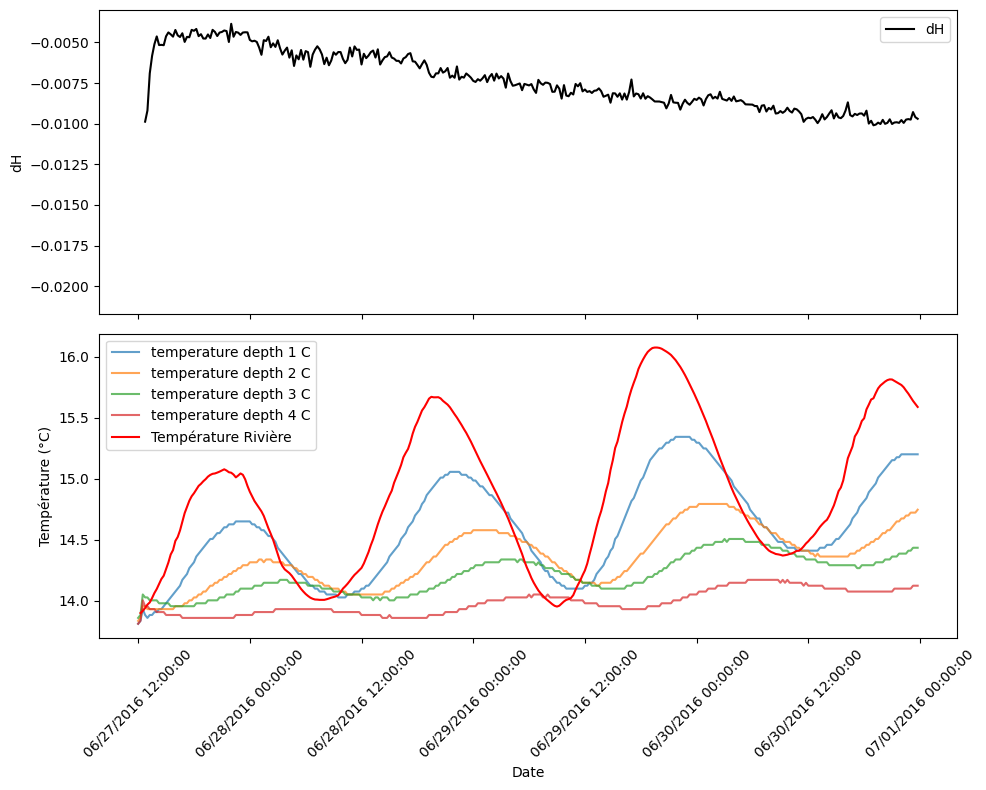

In [100]:
# Utilisez la fonction plot_data pour tracer les données traitées
capteur_ZH_process2=df_processed2[["dates_parsed", "temperature_depth_1_C", "temperature_depth_2_C", "temperature_depth_3_C", "temperature_depth_4_C"]].copy()
capteur_riviere_process2=df_processed2[["dates_parsed","temperature_stream_C","dH"]].copy()


plot_data(capteur_riviere_process2, capteur_ZH_process2)


### Essayer en modifant la valeur du  threshold

### Faire une fonction pour adapter le  threshold à chaque colonne


### Comparer les deux méthodes

# Tracer la pluie et la température

# Faire une fonction pour vérifier si le régime est infiltrant ou exfiltrant
* dH negatif exfiltrant
* dH positif infiltrant


# Comparer la coherance avec les données de pluie

# Comparer si cela est visible dans les profiles de température

# Concluez sur la fonction pour déterminer si la station peut être analysée ou non. Proposez d'autres tests et optimisez les fonctions